# **Importing Dependencies and Dataset**
We import all the required libraries and mount drive so as to get the dataset.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import glob
import numpy as np
import csv
import pandas as pd
import random
from music21 import converter, instrument ,note ,chord ,stream
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
from google.colab import files
drive.mount("/content/gdrive")

Mounted at /content/gdrive



# **Using a GPU**

To seamlessly use GPU, if one is available, we define a couple of header functions (get_default_device & to_device) and a helper class DeviceDataLoader to move our model and data to the GPU as required.

In [ ]:
def get_default_device():
  """pick GPU if available , else GPU"""
  if torch.cuda.is_available():
    return torch.device('cuda')
  else: 
    return torch.device('cpu')

def to_device(data ,device):
  """Move tensor(s) to chosen device"""
  if isinstance(data,(list,tuple)):
    return [to_device(x,device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  """Wrap a dataloader to move data to a device"""
  def __init__(self,dl,device):
    self.dl=dl
    self.device=device

  def __iter__(self):
    """Yield a batch of data after moving ot to device"""
    for b in self.dl:
      yield to_device(b,self.device)

  def __len__(self):
    """Number of Batches"""
    return len(self.dl)

In [ ]:
"""Setting up cuda device"""
device = get_default_device()
device

device(type='cuda')

# **Conversion of MIDI files**

We must define functions to convert MIDI files to usable data formats.

In [ ]:
def convert_midi_to_notes(file):
  """Convets midi files to musical notes"""
  
  notes=[]
  midi =converter.parse(file)
  notes_to_parse=None
  parts =instrument.partitionByInstrument(midi)

  if parts: #file has instrument parts
    notes_to_parse=parts.parts[0].recurse()
  else:
    notes_to_parse=midi.flat.notes_to_parse

  for i,element in enumerate(notes_to_parse):
    if isinstance(element,note.Note): #if the element is instance of note
        notes.append(str(element.pitch))
    elif isinstance(element,note.Rest):# if the element is instance of the Rest Object
      notes.append('rest')
    elif isinstance(element,chord.Chord):# if element is instance of chord
      notes.append(','.join(str(n) for n in element.normalOrder))

  return notes

In [ ]:
#two helper functions to save us from the pain of waiting for too long preprocessing time
def convert_to_csvN(notes):
  """Converts list of notes to csv format"""
  df=pd.DataFrame(notes)
  df.to_csv('csv_DataSet.csv',index=False)

def convert_to_csvL(notes):
  """Converts list of length of files to csv format"""
  df=pd.DataFrame(notes)
  df.to_csv('csv_Length.csv',index=False)

def create_data_set_fromCSVN(NameOfFile):
  """Creates dataset from already pre-processed data that has been stored in the form of csv"""
  f=open(NameOfFile)
  csv_reader=csv.reader(f)
  notes=[]
  for row in csv_reader:
    notes+=row
  
  #done to remove unwanted '0' string 
  del notes[0]
  
  return notes

def create_data_set_fromCSVL(NameOfFile):
  """Creates List of length of notes of files """
  f=open(NameOfFile)
  csv_reader=csv.reader(f)
  notes=[]
  for row in csv_reader:
    notes+=[int(row[0])]
  
  #done to remove unwanted '0' string 
  del notes[0]
  
  return notes

# **Dataset Preparation** 

In [ ]:
def conv_notes_to_dict(notes):
  """converts notes into a dictionary that uses notes as keys and values as serial integers as values"""
  
  pitchnames=set(item for item in notes)

  notes_to_int =dict((notes,number) for number, notes in enumerate(pitchnames))

  return notes_to_int

In [ ]:
def create_dataset(notes_to_int,notes,l,sequence_length=100,target_length=1):
  """Creates input and corresponding output sequence"""
  
  net_in=[]
  net_out=[]
  count=0
  for j in range(len(l)):

    for i in range(count,count+l[j]-sequence_length,1):
      seq_in=notes[i:i+sequence_length]
      seq_out=notes[i+sequence_length]
      net_in.append([notes_to_int[c] for c in seq_in])
      net_out.append(notes_to_int[seq_out])
    count+=l[j]

  n_pattern= len(net_in)

  net_in =np.reshape(net_in,(n_pattern,sequence_length,1))

  net_out=np.array(net_out)

  return net_in ,net_out

In [ ]:
def prepare_input_dataLoader(input,batch_size):
  """Prepare train_dl and corresponding out_loader"""
  
  train_loader=torch.utils.data.DataLoader(input ,batch_size=batch_size,shuffle=False,num_workers=2)
  return train_loader

def prepare_output_dataLoader(output, batch_size):
  out_loader =torch.utils.data.DataLoader(output, batch_size=batch_size,shuffle=False,num_workers=2)
  return out_loader

In [ ]:
#Extracting notes from the music files in GDrive
notes=[]
length_of_files=[]

for file in glob.glob('/content/gdrive/MyDrive/whole/*.mid'):
  n=convert_midi_to_notes(file)
  if len(n)>100:
    notes+=n
    length_of_files.append(len(n))

convert_to_csvN(notes)
convert_to_csvL(length_of_files)

In [ ]:
notes=create_data_set_fromCSVN('csv_DataSet(312)Notes+Chords.csv')
length_of_files=create_data_set_fromCSVL('csv_Length(312)Notes+Chords.csv')

In [ ]:
"""
Pitchnames: Our Vocabulary of the notes ,chord and rest objects extracted from music files
notes_to_int: Dictionary that maps unique notes to an integer
net_in: input data
net_out: expected output
"""
pitchnames =sorted(set(notes))
notes_to_int =conv_notes_to_dict(notes)
net_in , net_out =create_dataset(notes_to_int,notes,length_of_files,100)

n_vocab=len(set(notes))

In [ ]:
print("Input Shape",net_in.shape)
print("Total Vocab Size",len(pitchnames))
print("Pitchnames",sorted(pitchnames))

Input Shape (183329, 100, 1)
Total Vocab Size 379
Pitchnames ['0', '0,1', '0,1,3,6,8', '0,1,4', '0,2', '0,2,5', '0,2,5,8', '0,2,6', '0,2,6,8', '0,2,7', '0,3', '0,3,5', '0,3,5,8', '0,3,6', '0,3,6,8', '0,3,6,9', '0,3,7', '0,4', '0,4,5', '0,4,6', '0,4,7', '0,4,8', '0,5', '0,5,6', '0,6', '1', '1,2', '1,2,4,8', '1,2,5', '1,2,5,8', '1,2,6', '1,3', '1,3,5,9', '1,3,6', '1,3,6,8', '1,3,7', '1,3,7,9', '1,3,8', '1,4', '1,4,5', '1,4,6', '1,4,7', '1,4,7,10', '1,4,7,9', '1,4,8', '1,5', '1,5,7', '1,5,8', '1,5,9', '1,6', '1,7', '10', '10,0', '10,0,2,5', '10,0,2,5,7', '10,0,3', '10,0,3,6', '10,0,4', '10,0,5', '10,1', '10,1,3', '10,1,3,6', '10,1,4', '10,1,4,6', '10,1,5', '10,11', '10,11,2,5', '10,11,3', '10,11,3,6', '10,2', '10,2,3', '10,2,3,5', '10,2,4', '10,2,5', '10,3', '10,3,4', '11', '11,0', '11,0,2,5,7', '11,0,4', '11,1', '11,1,2', '11,1,2,4', '11,1,4', '11,1,4,6', '11,1,5', '11,1,6', '11,2', '11,2,3', '11,2,4', '11,2,4,6', '11,2,5', '11,2,5,7', '11,2,6', '11,3', '11,3,4', '11,3,5', '11,3,6', '11,

In [ ]:
net_in =torch.from_numpy(net_in).to(torch.int32)
net_out =torch.from_numpy(net_out).to(torch.int64)

train_dl =DeviceDataLoader(prepare_input_dataLoader(net_in,128),device)
out_dl =DeviceDataLoader(prepare_output_dataLoader(net_out,128),device)

# **Model Definition**
The following cells define the model, its parameters, the encoder-decoder along with the attention mechanism. 

In [ ]:
class EncoderLSTM(nn.Module):
  def __init__(self,input_size,embedding_size,hidden_size,num_layers,dropout,bidirectional=False):
    """Initialising encoder class 
    Args:
        input_size: The number of expected features in the input x
        embedding_size: The size of embedding layer to be used 
        hidden_size: The number of hidden features expected
        num_layers: number of layers of lstm to be used 
        dropout: Defined the dropout fraction of lstm layer
        bidirectional: defines whether the lstm layer is bidirectional or not
    """
    super(EncoderLSTM,self).__init__()
    self.input_size=input_size
    self.hidden_size=hidden_size
    self.drop_f=dropout
    self.bi_dir=bidirectional
    
    self.embedding=nn.Embedding(input_size,embedding_size)
    self.lstm=nn.LSTM(embedding_size,hidden_size,num_layers,bidirectional=bidirectional,batch_first=True)

    self.fc_hidden=nn.Linear(hidden_size*2,hidden_size)
    self.fc_cell=nn.Linear(hidden_size*2,hidden_size)

  def forward(self,x):
    """Defines computation performed at every call"""

    x=x.squeeze(2)
    # x is of size (BATCH_SIZE,SEQUENCE_LENGTH)
    embedded=self.embedding(x)
    #embedded shape : (BATCH_SIZE,SEQUENCE_LENGTH,EMBEDDING_SIZE)

    output=embedded
    encoder_states,(hidden,cell)=self.lstm(output)
    #encoder_states shape: (BATCH_SIZE,SEQUENCE_LENGTH,(1+int(self.bi_dir))*HIDDEN_SIZE)
    #hidden shape: ((1+int(self.bi_dir))*NUM_LAYERS,BATCH_SIZE,HIDDEN_SIZE)

    # if the encoder is bidirectional
    if self.bi_dir:
      hidden=self.fc_hidden(torch.cat((hidden[0:1],hidden[1:2]),dim=2))
      cell=self.fc_hidden(torch.cat((cell[0:1],cell[1:2]),dim=2))

    return encoder_states,hidden,cell
    

In [ ]:
class AttentionDecoderLSTM(nn.Module):
  def __init__(self,input_size,embedding_size,hidden_size,output_size,num_layers,drop,en_bi=False):
    """Initializes Attention decoder
      Args:
        input_size: The number of expected features in the input x
        embedding_size: The size of embedding layer to be used 
        output_size: The number of output features expected (will be equal to vocab size in this case)
        num_layers: number of layers of lstm to be used 
        drop: Defined the dropout fraction of lstm layer
        en_bi: defines whether the encoder is bidirectional or not
    """
    super(AttentionDecoderLSTM,self).__init__()
    self.hidden_size=hidden_size
    self.num_layers=num_layers
    self.bi=en_bi

    self.embedding=nn.Embedding(input_size,embedding_size)
    self.lstm=nn.LSTM(hidden_size*(1+int(self.bi))+embedding_size,hidden_size,num_layers,batch_first=True,dropout=drop)

    self.e= nn.Linear(hidden_size*(2+self.bi),1)
    self.fc =nn.Linear(hidden_size,output_size)
    self.softmax=nn.Softmax(dim=1)
    self.relu=nn.ReLU()

  def forward(self,x,encoder_states,hidden,cell):
    """Defines the computation performed at every call"""

    # x shape :(BATCH_SIZE,1)
    #encoder_states :(BATCH_SIZE,SEQUENCE_LENGTH,(1+int(self.bi))*HIDDEN_SIZE)

    embedding=self.embedding(x)
    # embedding shape: (BATCH_SIZE,1,EMBEDDING_SIZE)

    h_reshaped=hidden.repeat(100,1,1)
    #h_reshaped shape: (SEQUENCE_LENGTH,BATCH_SIZE,HIDDEN_SIZE)

    h_reshaped=h_reshaped.permute(1,0,2)
    #h_reshaped shape: (BATCH_SIZE,SEQUENCE_LENGTH,HIDDEN_SIZE)

    alignment_score =self.relu(self.e(torch.cat((h_reshaped,encoder_states),dim=2)))
    #alignment_score shape: (BATCH_SIZE,SEQUENCE_LENGTH,1)

    attn_weights= self.softmax(alignment_score)
    #attn_weights : (BATCH_SIZE,SEQUENCE_LENGTH,1)

    #attn_weights : (BATCH_SIZE,SEQUENCE_LENGTH,1)-->nsk
    #encoder_states : (BATCH_SIZE,SEQUENCE_LENGTH,HIDDEN_SIZE*(1+int(self.bi)))-->nsl
    #context vector : (BATCH_SIZE,1,HIDDEN_SIZE*(1+int(self.bi)))-->nkl
    context_vector=torch.einsum("nsk,nsl->nkl",attn_weights,encoder_states)
    #torch.einsum will carry out the matrix multiplication in way it is defined using 
    #string.In this case it will first permute the attn_weights then carry out regular 
    #batch matrix multiplication.Above line is similar to torch.bmm(attn_weights.permute(0,2,1),encoder_states)

    lstm_input =torch.cat((context_vector,embedding),dim=2)
    #lstm_input shape :(BATCH_SIZE,1,HIDDEN_SIZE*(1+int(self.bi))+EMBEDDING_SIZE)

    lstm_out,(hidden,cell) =self.lstm(lstm_input,(hidden,cell))
    #lstm_out shape: (BATCH_SIZE,1,HIDDEN_SIZE)

    decoder_out =self.fc(lstm_out).squeeze(1)
    #decoder_out shape: (BATCH_SIZE,OUTPUT_SIZE)

    return decoder_out,hidden,cell


In [ ]:
class AttnModel(nn.Module):
  def __init__(self,encoder,deocder):
    """Initialising our model class with encoder and decoder to be used together as a unit
            encoder: EncoderLSTM
            decoder: AttentionDecoderLSTM
    """
    super(AttnModel,self).__init__()
    self.encoder=encoder
    self.decoder=decoder

  def forward(self,input,target=None,teacher_fr=0.5,train=False):
    """Defined the computation performed at every call """

    #batch_size of input data
    batch_size=input.shape[0]

    #target length desired
    if target is not None:
      target_len=target.shape[1] if len(target.shape)==2 else 1
    else:
      target_len=1

    #Vocabulary size
    target_n_vocab=n_vocab

    outputs =torch.zeros(batch_size,target_len,target_n_vocab).to(device)
    encoder_states,hidden,cell=self.encoder(input)

    # x shape: (1,1)
    x=torch.tensor([[n_vocab]],device=device)
    x=x.repeat(batch_size,1)
    # x shape: (BATCH_SIZE,1)

    for t in range(0,target_len):
      decoder_out,hidden,cell =self.decoder(x,encoder_states,hidden,cell)

      outputs[:,t]=decoder_out

      #pred shape: (BATCH_SIZE,1)
      pred =decoder_out.argmax(1)

      if train:
        x=target[:,t] if random.random()<teacher_fr else pred.to(torch.int32)

      else:
        x=pred.to(torch.int32)

    outputs=outputs.squeeze(1)
    return outputs

# **Model Training**
We define all the hyperparameters below and train the trainer. 

In [ ]:
#hyperparameters for training
EPOCHS=100
lr=0.001
batch_size=128

#model parameters
encoder_input_size=n_vocab
decoder_input_size=n_vocab+1
decoder_output_size=n_vocab
output_size=n_vocab
encoder_embedding_size=64
decoder_embedding_size=64
hidden_size=256
num_layers=1
drop=0

In [ ]:
#encoder-decoder initialization
encoder=to_device(EncoderLSTM(input_size=encoder_input_size,embedding_size=encoder_embedding_size,hidden_size=256,num_layers=num_layers,dropout=drop,bidirectional=False),device)
decoder=to_device(AttentionDecoderLSTM(input_size=decoder_input_size,embedding_size=decoder_embedding_size,hidden_size=hidden_size,output_size=output_size,num_layers=num_layers,drop=drop),device)

In [ ]:
#model initialisation for AttnModel
model=to_device(AttnModel(encoder,decoder),device)
model

AttnModel(
  (encoder): EncoderLSTM(
    (embedding): Embedding(379, 64)
    (lstm): LSTM(64, 256, batch_first=True)
    (fc_hidden): Linear(in_features=512, out_features=256, bias=True)
    (fc_cell): Linear(in_features=512, out_features=256, bias=True)
  )
  (decoder): AttentionDecoderLSTM(
    (embedding): Embedding(380, 64)
    (lstm): LSTM(320, 256, batch_first=True)
    (e): Linear(in_features=512, out_features=1, bias=True)
    (fc): Linear(in_features=256, out_features=379, bias=True)
    (softmax): Softmax(dim=1)
    (relu): ReLU()
  )
)

In [ ]:
train_losses=[]
#defining loss function
loss_fn=nn.CrossEntropyLoss()
# defining optimizer for our model
optimizer=torch.optim.Adam(model.parameters(),lr)

#training of model
for epoch in range(EPOCHS):
  model.train()
  avg_loss=0.0
  
  for i ,(in_batch,out_batch) in enumerate(zip(train_dl,out_dl)):
    output=model(in_batch,out_batch)
    loss=loss_fn(output,out_batch)
    avg_loss+=loss.item()
    loss.backward(retain_graph=True)
    optimizer.step()
    optimizer.zero_grad()

    if i==len(train_dl)-1:
      print("Epoch[{}/{}],train_loss: {:.5f}".format(epoch,EPOCHS,float(avg_loss/len(train_dl))))
      train_losses.append(float(avg_loss/len(train_dl)))

Epoch[0/100],train_loss: 4.13199
Epoch[1/100],train_loss: 3.50085
Epoch[2/100],train_loss: 3.16293
Epoch[3/100],train_loss: 2.84604
Epoch[4/100],train_loss: 2.53736
Epoch[5/100],train_loss: 2.25061
Epoch[6/100],train_loss: 1.99076
Epoch[7/100],train_loss: 1.76501
Epoch[8/100],train_loss: 1.57042
Epoch[9/100],train_loss: 1.40044
Epoch[10/100],train_loss: 1.25443
Epoch[11/100],train_loss: 1.13349
Epoch[12/100],train_loss: 1.01810
Epoch[13/100],train_loss: 0.91894
Epoch[14/100],train_loss: 0.83561
Epoch[15/100],train_loss: 0.76117
Epoch[16/100],train_loss: 0.69467
Epoch[17/100],train_loss: 0.64616
Epoch[18/100],train_loss: 0.58690
Epoch[19/100],train_loss: 0.54477
Epoch[20/100],train_loss: 0.50219
Epoch[21/100],train_loss: 0.47479
Epoch[22/100],train_loss: 0.45479
Epoch[23/100],train_loss: 0.41981
Epoch[24/100],train_loss: 0.38544
Epoch[25/100],train_loss: 0.37184
Epoch[26/100],train_loss: 0.36230
Epoch[27/100],train_loss: 0.33518
Epoch[28/100],train_loss: 0.31308
Epoch[29/100],train_loss

# **Saving & Loading the Model**
The following cells save all the parameters of the trained model and also prepares them to be loaded to the generator. 



In [ ]:
#torch.save used for saving our model in the file model_data.pth
torch.save(model.state_dict(),'model_data.pth')

# download the file
# helper library provided by colab to deal with files, in this case downloading automatically
files.download('model_data.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#loading the model in state_dict
state_dict=torch.load('model_data.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

# **Music Generation and Analysis**
The following cells contain the code that will be run to generate the music.



In [ ]:
def generate_notes(model ,network_input,network_output,pitchnames ,n_vocab):
  """Generate notes from the neural network based on a sequence of notes"""
  # pick a random sequence from the input as staring point for the prediction

  # to generate a seed from the song by randomly selecting a sequence from the given music
  start =np.random.randint(0,len(network_input)-1) 

  # this is to map notes from the integers 
  int_to_note =dict((number,note) for number ,note in enumerate(pitchnames))

  pattern =network_input[start] #will return a tensor of size(100,1)
  p_out=network_output[start]
  prediction_output =[] #empty list to be appended by the output ,which will be returned eventually in the end
  
  #generate 500 notes
  for note_index in range(300):

    #prediction_input should be of size (1,SEQUENCE_LENGTH,1)
    #prediction_input being transfered to cuda device
    prediction_input =torch.reshape(pattern ,((1,len(pattern),1))).to(device)

    #prediction being made from the given input,size(1,NUM_CLASSES)
    prediction = model(prediction_input,p_out)

    #gives the tensor form with only single element
    index =torch.argmax(prediction) 
    #gives integer
    index=index.item()  
    #integer index being converted to note again            
    result =int_to_note[index]     
    #output prediction being made 
    prediction_output.append(result)
    
    index =torch.tensor([index])
    index =index.reshape(1,1)
    
    pattern= torch.cat((pattern,index),dim=0)
    pattern =pattern[1:].to(torch.int32)
  
  return prediction_output

In [ ]:
def convert_to_midi(prediction_output):
  """convert the output from the prediction to notes and create midi file from 
  the notes"""
  offset=0
  output_notes=[]
  #create note and chord objects based on the values generated by the model
  for pattern in prediction_output:
    #pattern is a chord
    if (',' in pattern) or pattern.isdigit():
      notes_in_chord=pattern.split(',')
      notes=[]
      for current_note in notes_in_chord:

        new_note=note.Note(int(current_note))
        new_note.storedInstrument =instrument.Piano()
        notes.append(new_note)

      new_chord=chord.Chord(notes)
      new_chord.offset= offset
      output_notes.append(new_chord)
      #pattern is a note
    elif pattern=='rest':
      new_rest=note.Rest(pattern)
      new_rest.offset=offset
      new_rest.storedInstrument=instrument.Piano()
      output_notes.append(new_rest)
    
    else:
      new_note=note.Note(pattern)
      new_note.offset=offset
      new_note.storedInstrument=instrument.Piano()
      output_notes.append(new_note)

    offset+=0.5
    #increase offset each iteration so that notes do not stack

  midi_stream =stream.Stream(output_notes)

  midi_stream.write('midi',fp='/content/test_output.mid')

In [ ]:
# generate_notes function defined above makes prediction of 
# notes using trained model and returns a list
pred=generate_notes(model,net_in,net_out,pitchnames,n_vocab)

In [ ]:
#predction notes will be printed
print(pred)

['5,7,0', '1,5', '8,11,2', '3,6,10', '3', 'B6', '5,8', '5,10', '5,7,10', '4,5,10', '1,5', 'F#6', '4,9,10', '5,7,0', 'B6', '5,8', '5,10', '5,7,10', '4,5,10', '1,5', 'F#6', '8,9,1', 'B6', '5,7,0', 'B6', '5,7,10', '3,6,10', '8,9,1', 'B6', '5,8', '11,3,6', '5,8', '8,9,1', 'B6', '11,3,6', '8,9,1', 'B6', '5,8', '6,8,10,2', 'B6', '2,5,8,11', '11,3,6', '8,9,1', 'B6', 'G#4', '6,8,10,2', '3', '10,0,2,5,7', '5,7,0', '2,5,8,11', '4,7', '5,7,10', '2,5,8,11', '5', '4,7', '9,11,3', '11,2,6', '9,11,3', 'B6', '4,5,10', '6,8,10,2', '6,9,11,2', 'B6', '8,9,1', '7,10,1,3', '9,11,3', 'B6', '11,3,6', '10,0,2,5,7', '8,9,1', '0,1,4', 'B6', '11,2,6', '1,2,5', '8,9,1', '11,2,6', 'B6', '5,7,10', '3,6,10', '8,9,1', '8,11,2', '11,3,6', '6,8,10,2', '9,11,3', 'B6', '11,3,6', '7,11', '8,9,1', '10,0,2,5', '9,0,4', '5,7,0', '11,3,6', '4,8', '3', '11,2,6', '3,6,10', '8,11,2', '5,10', '5,7,0', '4,7,10', '8,11,2', '5,10', '11,3,6', 'G3', '10,1,3,6', '3,6,8', '11,3,6', '4,7,10', '11,3,6', '8,11,2', '5,10', 'D4', '11,3,6', '

In [ ]:
#converting the prediction list of notes to
convert_to_midi(pred)
files.download('test_output.mid')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

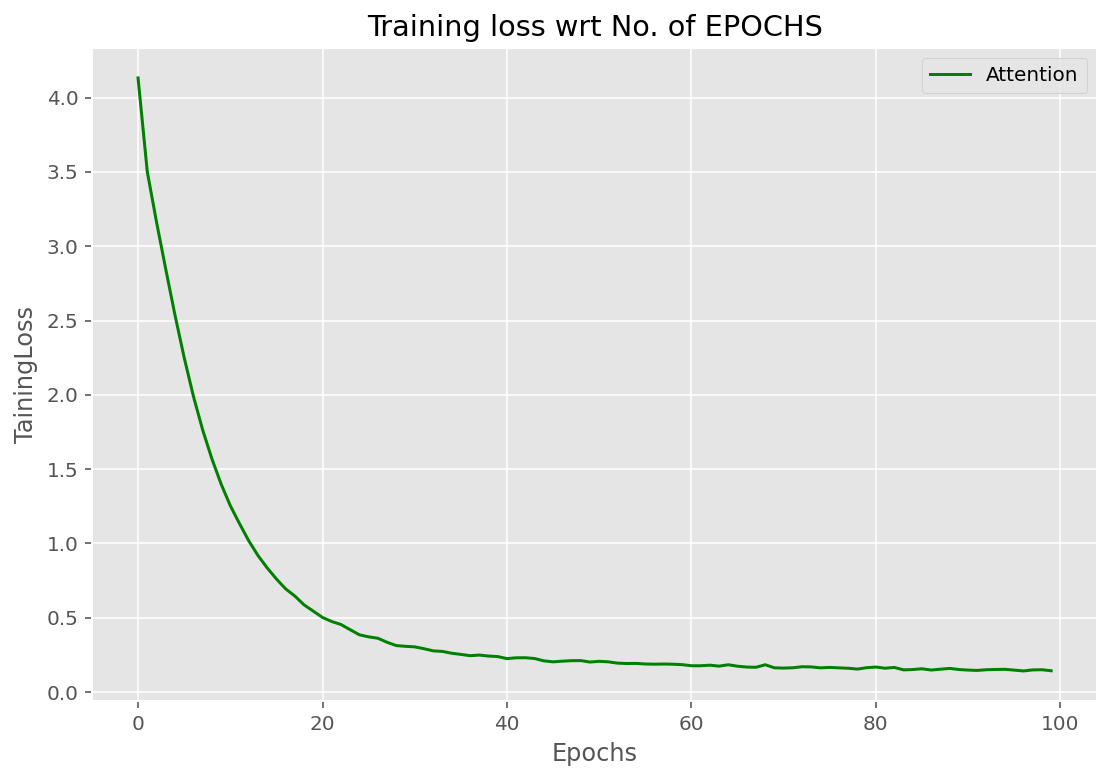

In [ ]:
from IPython.display import HTML, display

display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))
plt.style.use( 'ggplot')
plt.figure(figsize=(9,6))
plt.plot(range(len(train_losses)),train_losses,label='Attention',color='green')
plt.xlabel('Epochs')
plt.ylabel('TainingLoss')
plt.title('Training loss wrt No. of EPOCHS')
plt.legend()
plt.show()